## Загрузим нужные библиотеки

In [1]:
!pip install lightgbm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
import numpy as np
import tensorflow as tf 
from tensorflow import keras
%matplotlib inline

2022-10-21 14:05:37.593717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-21 14:05:37.726414: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-21 14:05:37.726436: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-21 14:05:37.761970: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-21 14:05:38.376195: W tensorflow/stream_executor/platform/de

В начале остановимся на наиболее перспективных навыках

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

df_calls = pd.read_csv("Calls.csv")
df_connection_time = pd.read_csv("ConnectionTime.csv")
df_ed = pd.read_csv("Education.csv")

/tmp/ipykernel_23723/2175504698.py:5: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_connection_time = pd.read_csv("ConnectionTime.csv")


## Рассмотрим датасет по ближе

In [3]:
df_calls.head(3)

,Date,CallTime,NumberOfCalls,Вид учета времени,InOut,id
0,"2021-08-16 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
1,"2021-09-21 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
2,"2021-01-11 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945


In [4]:
df_connection_time.head(3)

,dateNum,maxLogOff,Нормативное время начала раб.дня,Фактич. время начала раб.дня,Время опоздания,Признак опоздания,Вых/Будни,id
0,"2021-12-15 00:00:00,000","2021-12-15 17:30:27,246","1899-12-30 08:30:00,000","1899-12-30 08:24:18,606",NaN,NaN,Будни,ОРГ1-02782
1,"2021-12-15 00:00:00,000","2021-12-15 16:30:13,330","1899-12-30 08:30:00,000","1899-12-30 01:05:20,513",NaN,NaN,Будни,ОРГ1-01407
2,"2021-12-15 00:00:00,000","2021-12-15 15:27:37,246","1899-12-30 08:30:00,000","1899-12-30 05:47:33,156",NaN,NaN,Будни,ОРГ1-01909


In [5]:
df_connection_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230662 entries, 0 to 230661
Data columns (total 8 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   dateNum                           230662 non-null  object
 1   maxLogOff                         230662 non-null  object
 2   Нормативное время начала раб.дня  230662 non-null  object
 3   Фактич. время начала раб.дня      230662 non-null  object
 4   Время опоздания                   103101 non-null  object
 5   Признак опоздания                 77520 non-null   object
 6   Вых/Будни                         230662 non-null  object
 7   id                                230662 non-null  object
dtypes: object(8)
memory usage: 14.1+ MB


In [6]:
df_ed.head(3)

,Табельный номер руководителя,id,Вид образования,Специальность
0,NaN,ОРГ1-00131,Высшее образование - бакалавриат,Юриспруденция
1,NaN,ОРГ1-03220,Среднее профессиональное образование,Финансы
2,NaN,ОРГ1-03008,Высшее образование,Юриспруденция


In [7]:
df_train.head(3)

,id,type
0,ОРГ1-02050,2
1,ОРГ1-02783,2
2,ОРГ2-06173,0


In [8]:
df_test.head(3)

,id,type
0,ОРГ1-02649,0
1,ОРГ2-05929,0
2,ОРГ2-05859,0


Узнаем размерность наборов

In [9]:
print("df_train", df_train.shape)
print("df_calls", df_calls.shape)
print("df_connection_time", df_connection_time.shape)
print("df_ed", df_ed.shape)
print("df_test", df_test.shape)

df_train (550, 2)
df_calls (407867, 6)
df_connection_time (230662, 8)
df_ed (5609, 4)
df_test (262, 2)


### Видоизмение данных

Обьединим два набора с данными

In [10]:
df_train = pd.merge(df_train, df_ed , on="id", how='left').drop_duplicates(subset="id")

df_train.head(3)

,id,type,Табельный номер руководителя,Вид образования,Специальность
0,ОРГ1-02050,2,NaN,Неполное высшее образование,Технологические машины и оборудование
2,ОРГ1-02783,2,ОРГ1-01974,Высшее образование,Автоматизация технологических процессов и прои...
3,ОРГ2-06173,0,ОРГ2-01170,Высшее образование,Управление качеством


In [11]:
df_train = df_train.drop(["Табельный номер руководителя", "Специальность"],axis = 1)

df_train["Вид образования"].value_counts()

Высшее образование                                297
Среднее профессиональное образование               64
Высшее образование - бакалавриат                   59
Высшее образование - специалитет, магистратура     30
Начальное профессиональное образование              7
Повышение квалификации                              7
Неполное высшее образование                         5
Среднее общее образование                           3
Среднее (полное) общее образование                  2
Переподготовка                                      2
Профессиональное обучение                           1
Name: Вид образования, dtype: int64

In [12]:
df_train["Вид образования"] = df_train["Вид образования"].astype('category')
df_train["Вид образования"] = df_train["Вид образования"].cat.codes

df_train["Вид образования"].value_counts()

 0     297
-1      73
 10     64
 1      59
 2      30
 3       7
 6       7
 4       5
 9       3
 8       2
 5       2
 7       1
Name: Вид образования, dtype: int64

Оставим только столбец - опоздания сотрудников

In [13]:
df_connection_time_res = df_connection_time[["id","Признак опоздания"]]
df_connection_time_res = df_connection_time_res[df_connection_time_res["Признак опоздания"].notna()]

df_connection_time_res.head()

,id,Признак опоздания
127561,ОРГ1-01589,Опоздание
127562,ОРГ1-01589,Опоздание
127563,ОРГ1-01589,Опоздание
127564,ОРГ1-01589,Опоздание
127565,ОРГ1-01589,Опоздание


In [14]:
df_connection_time_res = df_connection_time_res.groupby("id").count()
df_connection_time_res = df_connection_time_res.rename(columns={"Признак опоздания": "Число опозданий"})

df_connection_time_res.head(3)

,Число опозданий
id,
ОРГ1-00004,275
ОРГ1-00028,35
ОРГ1-00030,57


In [15]:
df_train = pd.merge(df_train, df_connection_time_res , on="id", how='left')#.drop(["event_type"],axis =1)

df_train.head(3)

,id,type,Вид образования,Число опозданий
0,ОРГ1-02050,2,4,5.0
1,ОРГ1-02783,2,0,7.0
2,ОРГ2-06173,0,0,22.0


In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550 entries, 0 to 549
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               550 non-null    object 
 1   type             550 non-null    int64  
 2   Вид образования  550 non-null    int8   
 3   Число опозданий  491 non-null    float64
dtypes: float64(1), int64(1), int8(1), object(1)
memory usage: 17.7+ KB


## Добавим суммарное время звонков!



In [17]:
def str_to_float(str):
    if type(str)==float:
        return str
    str=str.replace(',','')
    return float(str)

df_calls['CallTime']=df_calls['CallTime'].map(str_to_float)
CallTime=pd.DataFrame(df_calls.groupby('id')['CallTime'].sum()).reset_index()
df_train = pd.merge(df_train, CallTime , on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime
0,ОРГ1-02050,2,4,5.0,4.810983e+18
1,ОРГ1-02783,2,0,7.0,1.350599e+19
2,ОРГ2-06173,0,0,22.0,NaN
3,ОРГ2-05359,2,10,6.0,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17
...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19
547,ОРГ1-02862,2,-1,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19


In [18]:
df_calls['NumberOfCalls'].value_counts()

1      140167
2       60780
3       33555
4       27493
5       19761
        ...  
107         1
105         1
114         1
98          1
95          1
Name: NumberOfCalls, Length: 102, dtype: int64

## Добавим колличество звонков в будни и выходные

In [19]:
NumberOfCalls=pd.DataFrame(df_calls.groupby('id')['NumberOfCalls'].sum()).reset_index()
df_calls= df_calls.rename(columns={'Вид учета времени': 'statusworkfre'})
NumberOfCallsW=pd.DataFrame(df_calls.query("statusworkfre=='Будни'").groupby('id')['NumberOfCalls'].sum()).reset_index()
NumberOfCallsNW=pd.DataFrame(df_calls.query("statusworkfre=='Выходные дни'").groupby('id')['NumberOfCalls'].sum()).reset_index()
df_train = pd.merge(df_train, NumberOfCalls , on="id", how='left')
df_train = pd.merge(df_train, NumberOfCallsW , on="id", how='left')
df_train = pd.merge(df_train, NumberOfCallsNW , on="id", how='left')
df_train


,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_x,NumberOfCalls_y,NumberOfCalls
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN
...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0


## Добавим колличество входящих и исходящих.

In [20]:
NumberToUser=pd.DataFrame(df_calls.query("InOut=='ToUser'").groupby('id')['NumberOfCalls'].sum()).reset_index()
NumberFromUser=pd.DataFrame(df_calls.query("InOut=='FromUser'").groupby('id')['NumberOfCalls'].sum()).reset_index() 
df_train = pd.merge(df_train, NumberToUser , on="id", how='left')
df_train = pd.merge(df_train, NumberFromUser , on="id", how='left')

/tmp/ipykernel_23723/762760274.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'NumberOfCalls_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_train = pd.merge(df_train, NumberToUser , on="id", how='left')


## Добавим суммарное время опазданий

In [21]:
df_connection_time['Время опоздания']=df_connection_time['Время опоздания'].map(str_to_float)
falout=pd.DataFrame(df_connection_time.groupby('id')['Время опоздания'].sum()).reset_index() 
df_train = pd.merge(df_train, falout , on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_x,NumberOfCalls_y,NumberOfCalls_x,NumberOfCalls_y,NumberOfCalls,Время опоздания
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,2.361381e+17
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,2.532397e+17
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,1.200253e+18
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1.657396e+17
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,9.288578e+17
...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,2.432262e+18
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,5.449973e+17


## Добавим дельту прихода на работу

In [22]:
df_connection_time['Нормативное время начала раб.дня']=pd.to_datetime(df_connection_time['Нормативное время начала раб.дня'])
df_connection_time['Фактич. время начала раб.дня']=pd.to_datetime(df_connection_time['Фактич. время начала раб.дня'])
df_connection_time['filtime']=df_connection_time['Нормативное время начала раб.дня']-df_connection_time['Фактич. время начала раб.дня']
filtime=pd.DataFrame(df_connection_time.groupby('id')['filtime'].mean().dt.total_seconds()).reset_index()
df_train = pd.merge(df_train, filtime , on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_x,NumberOfCalls_y,NumberOfCalls_x,NumberOfCalls_y,NumberOfCalls,Время опоздания,filtime
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,2.361381e+17,276.332096
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,2.532397e+17,-695.247628
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,1.200253e+18,-608.828839
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1.657396e+17,2186.244912
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,9.288578e+17,-14381.555892
...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,2.432262e+18,-7348.409864
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,5.449973e+17,-58.303964


In [23]:
# Сброс ограничений на количество выводимых рядов
#pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
#pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
#pd.set_option('display.max_colwidth', None)

## Добавим Профессию

In [24]:
prof=pd.DataFrame(df_ed['Специальность'].value_counts()).reset_index()
profhed=prof.head(457)
profhed['profcod']=profhed.index
proftail=prof.tail(623)
proftail['profcod']=999
profhed=profhed.append(proftail)
profhed= profhed.rename(columns={'index': 'specialisation'})
uniq = profhed['specialisation'].values
fifa = profhed['profcod'].values
uniq_and_fifa = dict(zip(uniq, fifa))
uniq_and_fifa
df_ed['Специальность']=df_ed['Специальность'].map(uniq_and_fifa)
professionstart=df_ed[['id','Специальность']].groupby('id')['Специальность'].min()
professionend=df_ed[['id','Специальность']].groupby('id')['Специальность'].max()
df_train = pd.merge(df_train, professionstart , on="id", how='left')
df_train = pd.merge(df_train, professionend , on="id", how='left')
df_train

/tmp/ipykernel_23723/2507229956.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profhed['profcod']=profhed.index
/tmp/ipykernel_23723/2507229956.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proftail['profcod']=999
/tmp/ipykernel_23723/2507229956.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  profhed=profhed.append(proftail)


,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_x,NumberOfCalls_y,NumberOfCalls_x,NumberOfCalls_y,NumberOfCalls,Время опоздания,filtime,Специальность_x,Специальность_y
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,2.361381e+17,276.332096,21.0,21.0
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,2.532397e+17,-695.247628,16.0,16.0
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,1.200253e+18,-608.828839,116.0,116.0
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1.657396e+17,2186.244912,999.0,999.0
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,9.288578e+17,-14381.555892,365.0,365.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,2.432262e+18,-7348.409864,24.0,24.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,5.449973e+17,-58.303964,136.0,160.0


## Добавим rколичество  руководителей

In [25]:
df_ed

,Табельный номер руководителя,id,Вид образования,Специальность
0,NaN,ОРГ1-00131,Высшее образование - бакалавриат,6.0
1,NaN,ОРГ1-03220,Среднее профессиональное образование,135.0
2,NaN,ОРГ1-03008,Высшее образование,6.0
3,NaN,ОРГ1-00922,Высшее образование - бакалавриат,999.0
4,NaN,ОРГ1-00922,Высшее образование,35.0
...,...,...,...,...
5604,ОРГ2-09100,ОРГ2-08601,Начальное профессиональное образование,55.0
5605,ОРГ2-09100,ОРГ2-08622,Начальное профессиональное образование,NaN
5606,ОРГ2-09100,ОРГ2-04773,Среднее профессиональное образование,275.0
5607,ОРГ2-09100,ОРГ2-05048,"Высшее образование - специалитет, магистратура",257.0


In [26]:
boss=df_ed.groupby('id')['Табельный номер руководителя'].count()

In [27]:
df_train = pd.merge(df_train, boss , on="id", how='left')

## Заменим пропуски на нули

In [28]:
df_train = df_train.fillna(0)

In [29]:
#df_train.append(df_train)


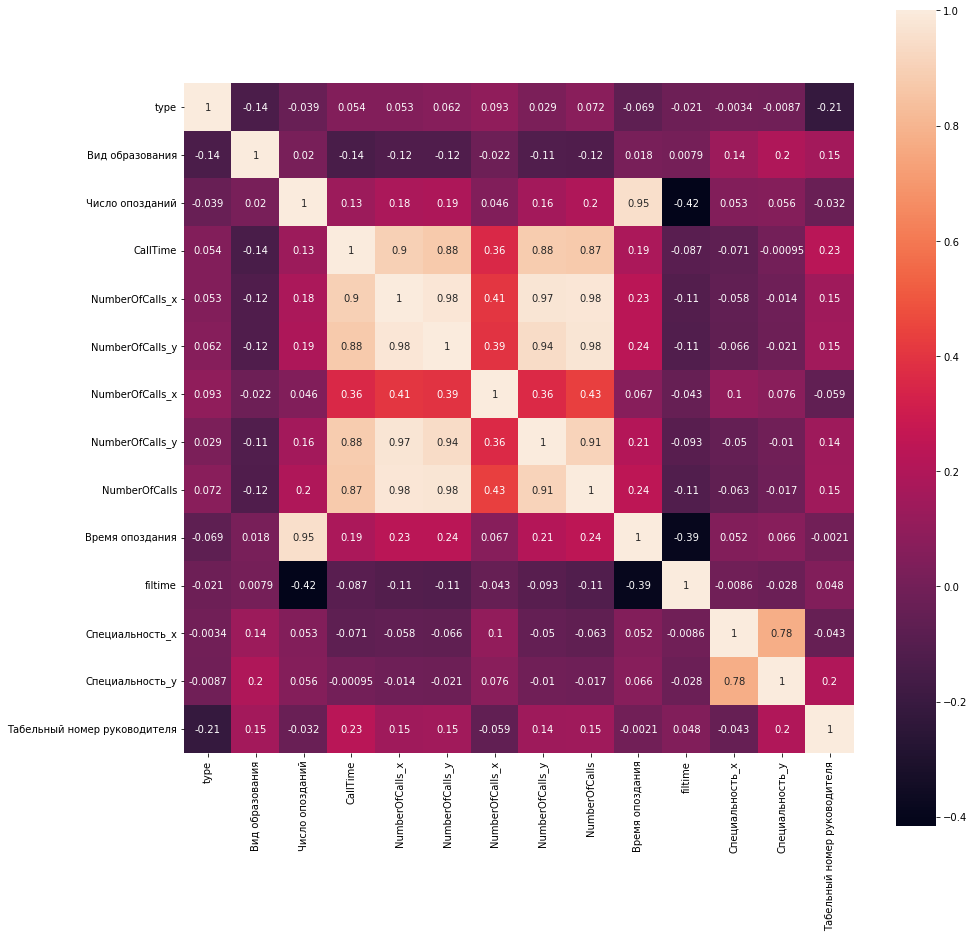

In [30]:
plt.rcParams['figure.figsize']=(15,15)

corr = df_train.corr()
g = sns.heatmap(corr, square = True, annot=True)

## Выделим выборки

In [31]:
X = df_train.drop(["id", "type",'NumberOfCalls_x','NumberOfCalls_y'], axis = 1)
y = df_train["type"]

# Стандартизация величин!

In [32]:
scaler = StandardScaler()
scaler.fit(X)
scaler.transform(X)

array([[ 0.73843104, -0.63704669, -0.26130887, ..., -0.48863881,
        -0.60754957, -0.74486448],
       [-0.44650572, -0.6014954 ,  0.54960802, ..., -0.50525918,
        -0.62152862,  0.22135124],
       [-0.44650572, -0.33486077, -0.70999231, ..., -0.17285182,
        -0.34194774,  0.22135124],
       ...,
       [-0.74273991, -0.7259249 , -0.70999231, ..., -0.55844436,
        -0.66626156, -0.74486448],
       [-0.74273991, -0.51261719,  0.92183569, ..., -0.10637035,
        -0.21893216, -0.74486448],
       [-0.74273991, -0.7259249 , -0.6979493 , ..., -0.55844436,
        -0.66626156, -0.74486448]])

In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550 entries, 0 to 549
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Вид образования               550 non-null    int8   
 1   Число опозданий               550 non-null    float64
 2   CallTime                      550 non-null    float64
 3   NumberOfCalls                 550 non-null    float64
 4   Время опоздания               550 non-null    float64
 5   filtime                       550 non-null    float64
 6   Специальность_x               550 non-null    float64
 7   Специальность_y               550 non-null    float64
 8   Табельный номер руководителя  550 non-null    float64
dtypes: float64(8), int8(1)
memory usage: 39.2 KB


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Обучение модели

In [35]:
clf = LGBMClassifier()


parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }
grid = GridSearchCV(clf, parametrs, cv=5,n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

In [36]:
clf.fit(X_train, y_train)

LGBMClassifier()

## Оценка точности

In [37]:
pred = clf.predict(X_test)

In [38]:
y_test.head(3)

195    2
79     2
480    0
Name: type, dtype: int64

In [39]:
from sklearn.metrics import recall_score

print("Recall score:", recall_score(y_test, pred, average='macro'))

Recall score: 0.47152093596059114


In [40]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57        14
           1       0.14      0.12      0.13         8
           2       0.67      0.69      0.68        29
           3       0.50      0.50      0.50         4

    accuracy                           0.56        55
   macro avg       0.47      0.47      0.47        55
weighted avg       0.55      0.56      0.56        55



## Генерация предсказания

In [41]:
df_test

,id,type
0,ОРГ1-02649,0
1,ОРГ2-05929,0
2,ОРГ2-05859,0
3,ОРГ1-00279,0
4,ОРГ2-01613,0
...,...,...
257,ОРГ1-02893,0
258,ОРГ2-01077,0
259,ОРГ1-00469,0
260,ОРГ1-02060,0


## Добавим фичи.

In [42]:
df_test = pd.merge(df_test, df_ed , on="id", how='left').drop_duplicates(subset="id")
df_test = df_test.drop(["Табельный номер руководителя", "Специальность"],axis = 1)
df_test["Вид образования"] = df_test["Вид образования"].astype('category')
df_test["Вид образования"] = df_test["Вид образования"].cat.codes
df_test = pd.merge(df_test, df_connection_time_res , on="id", how='left')#.drop(["event_type"],axis =1)

# Добавим суммарное время звоков

In [43]:
df_test = pd.merge(df_test, CallTime , on="id", how='left')

## Добавим колличество звонков в будни и выходные дни

In [44]:
df_test = pd.merge(df_test, NumberOfCalls , on="id", how='left')
df_test = pd.merge(df_test, NumberOfCallsW , on="id", how='left')
df_test = pd.merge(df_test, NumberOfCallsNW , on="id", how='left')

## Добавим колличество входящих и исходящих

In [45]:
df_test = pd.merge(df_test, NumberToUser , on="id", how='left')
df_test = pd.merge(df_test, NumberFromUser , on="id", how='left')

/tmp/ipykernel_23723/3207562534.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'NumberOfCalls_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_test = pd.merge(df_test, NumberToUser , on="id", how='left')


# Добавим суммарное время опоздания

In [46]:
df_test = pd.merge(df_test, falout , on="id", how='left')

# Добавим дельту прихода на работу

In [47]:
df_test  = pd.merge(df_test, filtime , on="id", how='left')

# Добавим профессию

In [48]:
profession=df_ed[['id','Специальность']].groupby('id')['Специальность'].min()
df_test = pd.merge(df_test, professionstart , on="id", how='left')
df_test = pd.merge(df_test, professionend , on="id", how='left')

In [49]:
df_test.head(50)

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_x,NumberOfCalls_y,NumberOfCalls_x,NumberOfCalls_y,NumberOfCalls,Время опоздания,filtime,Специальность_x,Специальность_y
0,ОРГ1-02649,0,-1,NaN,1.045278e+17,4.0,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN
1,ОРГ2-05929,0,1,19.0,NaN,NaN,NaN,NaN,NaN,NaN,9.550722e+17,-1057.019584,999.0,999.0
2,ОРГ2-05859,0,8,104.0,NaN,NaN,NaN,NaN,NaN,NaN,5.190126e+18,-2103.577020,NaN,NaN
3,ОРГ1-00279,0,0,15.0,3.790214e+19,8163.0,8134.0,29.0,3679.0,4484.0,5.900416e+17,-570.718116,4.0,4.0
4,ОРГ2-01613,0,2,17.0,NaN,NaN,NaN,NaN,NaN,NaN,1.839148e+18,-386.013125,4.0,4.0
5,ОРГ2-05171,0,9,13.0,NaN,NaN,NaN,NaN,NaN,NaN,6.101560e+17,3724.835381,138.0,138.0
6,ОРГ1-01873,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ОРГ1-01627,0,-1,35.0,NaN,NaN,NaN,NaN,NaN,NaN,3.158981e+18,-1135.199109,NaN,NaN
8,ОРГ1-01851,0,0,145.0,2.050829e+19,5943.0,5904.0,39.0,2142.0,3801.0,6.227878e+18,-7377.885927,180.0,180.0
9,ОРГ1-02815,0,0,164.0,1.672890e+19,2759.0,2713.0,46.0,1194.0,1565.0,7.095820e+18,-6982.961529,11.0,999.0


## Добавим колличество руководителей

In [50]:
df_test = pd.merge(df_test, boss , on="id", how='left')

# Удалим пустые значения

In [51]:
df_test = df_test.fillna(0)

In [52]:
df_test=df_test.drop(["id", "type",'NumberOfCalls_x','NumberOfCalls_y'], axis = 1)

## Предсказания

In [53]:
df_test_pred = pd.read_csv("test.csv")
Xpred = df_test
scaler.transform(Xpred)
preds = clf.predict(Xpred)
df_test_pred['type']=preds

In [54]:
df_test_pred.to_csv('rfnev.csv', index=False)

In [55]:
df_test_pred['type'].value_counts()

2    176
0     63
1     19
3      4
Name: type, dtype: int64